# 5. Routing 2: Route-based Construction Procedures
`ISE 754, Fall 2024`

__Package Used:__ No new packages used.

## Ex: Independent vs Consolidated Multi-Stop Shipments

#### Create Shipments

In [1]:
using Logjam.DataTools, DataFrames, CSV

function dgc(xy₁, xy₂; unit=:mi)
    length(xy₁) == length(xy₂) == 2 || error("Inputs must have length 2.")
    unit in [:mi, :km] || error("Unit must be :mi or :km")

    Δx, Δy = xy₂[1] - xy₁[1], xy₂[2] - xy₁[2]
    a = sind(Δy / 2)^2 + cosd(xy₁[2]) * cosd(xy₂[2]) * sind(Δx / 2)^2
    2 * asin(min(sqrt(a), 1.0)) * (unit == :mi ? 3958.75 : 6371.00)
end

Dgc(X₁, X₂) = [dgc(i, j) for i in eachrow(X₁), j in eachrow(X₂)]

function namest2lonlat(names, states, df)
    x, y = Float64[], Float64[]  
    for (name, st) in zip(names, states)
        idx = findfirst(r -> startswith(r[:NAME], name) && r[:ST] == st, eachrow(df))
        if idx === nothing
            error("'$name', '$st' not found in DataFrame")
        end
        push!(x, df[idx, :LON])
        push!(y, df[idx, :LAT])
    end
    return x, y
end

City = ["Raleigh", "Athens", "Asheville", "Jacksonville", "Savannah", "Gainesville"]
St = ["NC", "GA", "NC", "FL", "GA", "FL"]
x, y = namest2lonlat(City, St, usplace())
D = Dgc(hcat(x, y), hcat(x, y)) * 1.2

6×6 Matrix{Float64}:
   0.0    357.334  264.204  501.384   361.339  571.534
 357.334    0.0    145.502  322.643   223.212  361.17
 264.204  145.502    0.0    438.369   311.17   488.58
 501.384  322.643  438.369    0.0     142.725   73.4626
 361.339  223.212  311.17   142.725     0.0    210.475
 571.534  361.17   488.58    73.4626  210.475    0.0

In [2]:
sh = DataFrame(b = [1, 3, 5], e = [2, 4, 6])

Row,b,e
,Int64,Int64
1,1,2
2,3,4
3,5,6


#### Plot Independent Shipments

TD = sum((D[b, e] for (b, e) = zip(sh.b, sh.e))) = 1006.178484226333


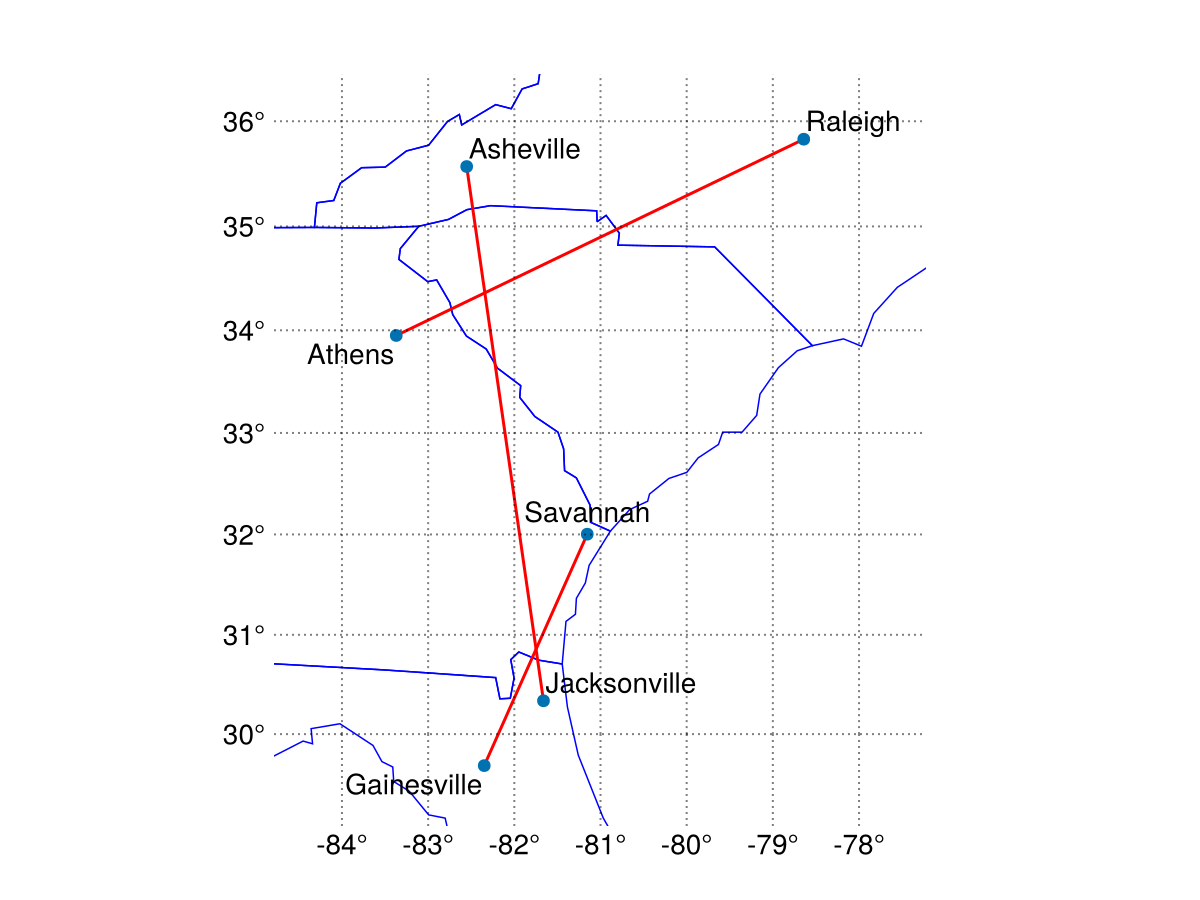

In [3]:
using CairoMakie, Logjam.MapTools

@show TD = sum(D[b, e] for (b,e) in zip(sh.b, sh.e))

fig, ax = makemap(x, y; xexpand=0.3)

x2ln(sh, x) = vcat(collect([x[b], x[e], NaN] for (b, e) in zip(sh.b, sh.e))...)

lines!(ax, x2ln(sh, x), x2ln(sh, y), color=:red)
scatter!(ax, x, y)
text!(ax, x, y, text=City; aligntext(x, y)...)
fig

#### Route Vector

In [4]:
isorigin(rte) = begin
    seen = Set()
    [i ∉ seen ? (push!(seen, i); true) : false for i in rte]
end

rte = [1, 2, 1, 3, 3, 2]
isorigin(rte)

6-element Vector{Bool}:
 1
 1
 0
 1
 0
 0

In [5]:
rte2loc(rte, sh) = ifelse.(isorigin(rte), sh[rte, :b], sh[rte, :e])

loc = rte2loc(rte, sh)
hcat(rte, loc)

6×2 Matrix{Int64}:
 1  1
 2  3
 1  2
 3  5
 3  6
 2  4

In [6]:
segcost(loc, C) = map(i -> C[loc[i], loc[i+1]], 1:length(loc) - 1)

d = segcost(loc, D)
@show sum(d)
d

sum(d) = 916.857351701912


5-element Vector{Float64}:
 264.204351839423
 145.50248974921337
 223.21239782780114
 210.47548717124184
  73.46262511423248

In [7]:
rteTC(rte, sh, C) = sum(segcost(rte2loc(rte, sh), C))
rteTC(rte, sh, D)

916.857351701912

In [8]:
rTDh(rte) = rteTC(rte, sh, D)
@show rTDh([1, 1])
@show rTDh([1, 1]) + rTDh([2, 2]) + rTDh([3, 3])
@show rTDh([1, 1, 2, 2]) + rTDh([3, 3])
@show rTDh([1, 2, 2, 1]) + rTDh([3, 3])
@show rTDh([1, 2, 1, 2]) + rTDh([3, 3])
@show rTDh([1, 2, 3, 1, 2, 3])
@show rTDh([1, 2, 1, 3, 3, 2])

rTDh([1, 1]) = 357.33414755808155
rTDh([1, 1]) + rTDh([2, 2]) + rTDh([3, 3]) = 1006.178484226333
rTDh([1, 1, 2, 2]) + rTDh([3, 3]) = 1151.6809739755465
rTDh([1, 2, 2, 1]) + rTDh([3, 3]) = 1235.691567290444
rTDh([1, 2, 1, 2]) + rTDh([3, 3]) = 942.8252075426478
rTDh([1, 2, 3, 1, 2, 3]) = 1194.692133793507
rTDh([1, 2, 1, 3, 3, 2]) = 916.857351701912


916.857351701912

### Min Cost Shipment Insertion Procedure
$\dfrac{n(n +3)}{2} - 1$ different routes evaluated when inserting a shipment into an $n$-shipment route. $n = 2 \implies 4, n = 4 \implies 13$ evaluations.

In [9]:
# Min cost insertion of shipment "idx" into route
function mincostinsert_prt(idx, rte, rteTCh)
    rteᵒ, TCᵒ = copy(rte), Inf
    for i = 1:length(rte)
        for j = max(2,i):length(rte) + 1
            rte′ = vcat(rte[1:i-1], idx, rte[i:j-1], idx, rte[j:end])
            TC = rteTCh(rte′)
            println(i,",",j,": ",rte′, " = ", TC)
            if TC < TCᵒ
                rteᵒ, TCᵒ = rte′, TC
            end
        end
    end
    return rteᵒ, TCᵒ
end

# insert shmt 2 route into shmt 1 route
@show rte12, TD12 = mincostinsert_prt(2, [1, 1], rTDh)
# insert shmt 3 route into shmt 1&2 route
rte123, TD123 = mincostinsert_prt(3, rte12, rTDh)

1,2: [2, 1, 2, 1] = 1088.230972928541
1,3: [2, 1, 1, 2] = 944.1813781802741
2,2: [1, 2, 2, 1] = 1025.2160801192022
2,3: [1, 2, 1, 2] = 732.349720371406
(rte12, TD12) = mincostinsert_prt(2, [1, 1], rTDh) = ([1, 2, 1, 2], 732.349720371406)
1,2: [3, 1, 3, 2, 1, 2] = 1889.598833775488
1,3: [3, 1, 2, 3, 1, 2] = 1797.936933665396
1,4: [3, 1, 2, 1, 3, 2] = 1205.6788394582027
1,5: [3, 1, 2, 1, 2, 3] = 1167.1515456662516
2,2: [1, 3, 3, 2, 1, 2] = 1528.5403861717077
2,3: [1, 3, 2, 3, 1, 2] = 1844.902462055254
2,4: [1, 3, 2, 1, 3, 2] = 1252.6443678480607
2,5: [1, 3, 2, 1, 2, 3] = 1214.1170740561097
3,3: [1, 2, 3, 3, 1, 2] = 1469.6627705974358
3,4: [1, 2, 3, 1, 3, 2] = 1233.219427585458
3,5: [1, 2, 3, 1, 2, 3] = 1194.692133793507
4,4: [1, 2, 1, 3, 3, 2] = 916.857351701912
4,5: [1, 2, 1, 3, 2, 3] = 849.1072994662491


([1, 2, 1, 3, 2, 3], 849.1072994662491)

#### Plot Consolidated Multi-Stop Route

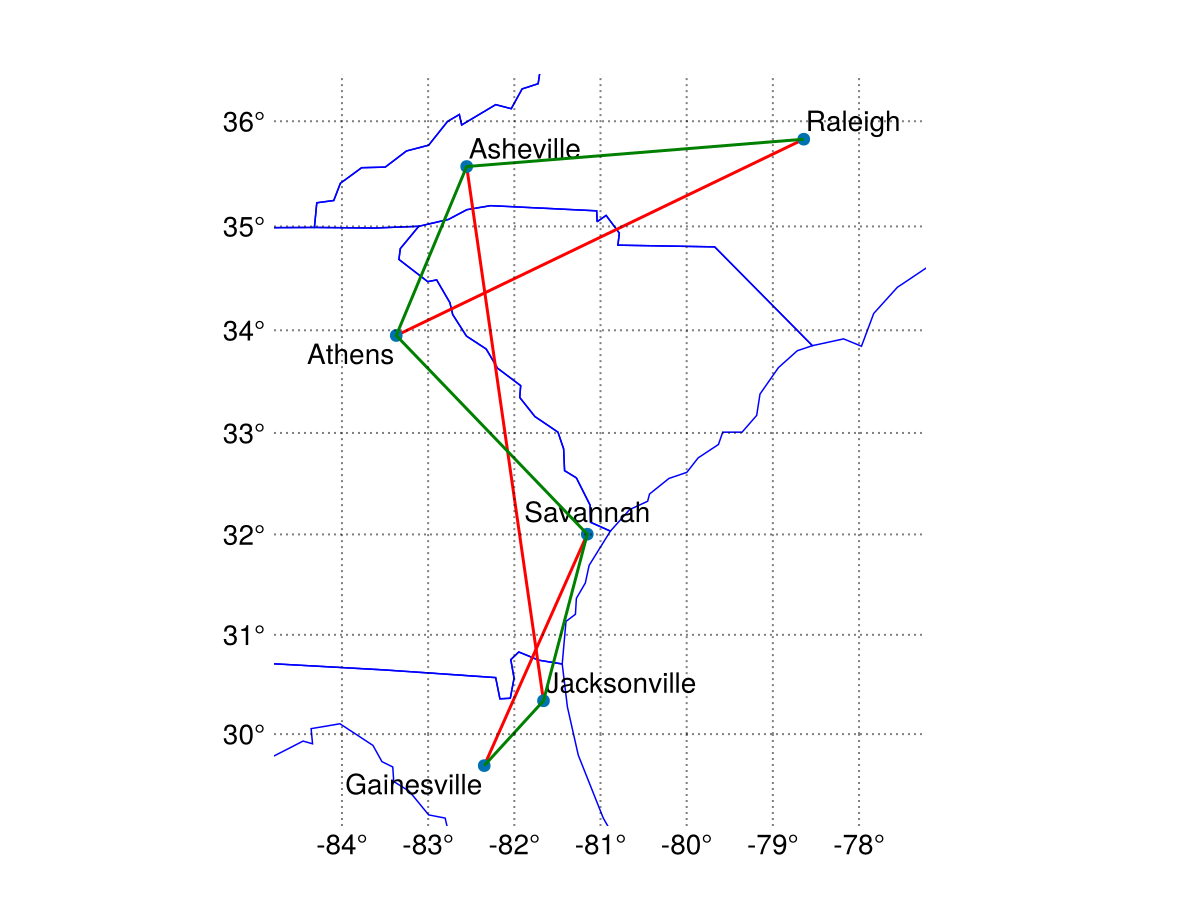

In [10]:
loc = rte2loc(rte123, sh)
lines!(ax, x[loc], y[loc], color=:green)
fig

### Pairwise Savings

In [11]:
@show c1 = rTDh([1, 1])
@show c2 = rTDh([2, 2])
@show c1 + c2
@show c12 = rTDh(rte12)
@show s12 = c1 + c2 - c12;

c1 = rTDh([1, 1]) = 357.33414755808155
c2 = rTDh([2, 2]) = 438.36884949700965
c1 + c2 = 795.7029970550911
c12 = rTDh(rte12) = 732.349720371406
s12 = (c1 + c2) - c12 = 63.35327668368518


In [12]:
function mincostinsert(idx, rte, rteTCh)
    rteᵒ, TCᵒ = copy(rte), Inf
    for i = 1:length(rte)
        for j = max(2,i):length(rte) + 1
            rte′ = vcat(rte[1:i-1], idx, rte[i:j-1], idx, rte[j:end])
            TC = rteTCh(rte′)
            if TC < TCᵒ
                rteᵒ, TCᵒ = rte′, TC
            end
        end
    end
    return rteᵒ, TCᵒ
end

mincostinsert (generic function with 1 method)

In [13]:
function pairwisesavings(rteTCh, sh)
    iᵒ, jᵒ, sᵒ = Int[], Int[], Float64[]
    for i = 1:nrow(sh)-1
        for j = i+1:nrow(sh)
            s = rteTCh([i, i]) + rteTCh([j, j]) - mincostinsert(i, [j, j], rteTCh)[2]
            s > 0 && (push!(iᵒ, i); push!(jᵒ, j); push!(sᵒ, s))
        end
    end
    sidx = sortperm(sᵒ, rev=true)
    return iᵒ[sidx], jᵒ[sidx], sᵒ[sidx]
end

ijs = pairwisesavings(rTDh, sh)
hcat(ijs...)

2×3 Matrix{Float64}:
 2.0  3.0  121.486
 1.0  2.0   63.3533

#### Savings Route Construction Procedure

In [14]:
function savings(rteTCh, sh)
    rte = [[i, i] for i in 1:nrow(sh)]
    inr = [1:nrow(sh);]
    iˢ, jˢ = pairwisesavings(rteTCh, sh)
    for (i, j) in zip(iˢ, jˢ)
        if inr[i] != inr[j]
            # Insert shmt from shorter (src) into longer (tgt) route
            inr_src, inr_tgt = length(rte[inr[i]]) < length(rte[inr[j]]) ?
                (inr[i], inr[j]) : (inr[j], inr[i])
            for k in unique(rte[inr_src])
                rte[inr_tgt] = mincostinsert(k, rte[inr_tgt], rteTCh)[1]
                inr[k] = inr_tgt
            end
            rte[inr_src] = []
        end
    end
    return filter!(!isempty, rte)
end

r = savings(rTDh, sh)

1-element Vector{Vector{Int64}}:
 [1, 2, 1, 3, 2, 3]

## Ex: Route-based TSP

Construct a tour from the previous example by adding a truck, `tr`, that starts from and returns to node 1 (Raleigh). Note, no shipment required for Raleigh since truck will return to Raleigh.

In [15]:
sh = DataFrame(b = ones(Int, 5), e = [2:6;])

Row,b,e
,Int64,Int64
1,1,2
2,1,3
3,1,4
4,1,5
5,1,6


In [16]:
rte = [1:5; 1:5]
isorigin(rte)

10-element Vector{Bool}:
 1
 1
 1
 1
 1
 0
 0
 0
 0
 0

In [17]:
tr = (b = 1, e = 1)
rte2loc(rte, sh, tr = (b = [], e = [])) = 
    vcat(tr.b, ifelse.(isorigin(rte), sh[rte, :b], sh[rte, :e]), tr.e)

loc = rte2loc(rte, sh, tr)
hcat(vcat(0, rte, 0), loc)

12×2 Matrix{Int64}:
 0  1
 1  1
 2  1
 3  1
 4  1
 5  1
 1  2
 2  3
 3  4
 4  5
 5  6
 0  1

In [18]:
hcat(rte, rte2loc(rte, sh))

10×2 Matrix{Any}:
 1  1
 2  1
 3  1
 4  1
 5  1
 1  2
 2  3
 3  4
 4  5
 5  6

In [19]:
hcat(vcat(rte, 0), rte2loc(rte, sh, (b = [], e = 1)))

11×2 Matrix{Any}:
 1  1
 2  1
 3  1
 4  1
 5  1
 1  2
 2  3
 3  4
 4  5
 5  6
 0  1

In [20]:
segcost(loc, C) = map(i -> C[loc[i], loc[i+1]], 1:length(loc) - 1)

loc = rte2loc(rte, sh, tr)
d = segcost(loc, D)
@show sum(d)
d

sum(d) = 1865.9403436861476


11-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
 357.33414755808155
 145.50248974921337
 438.36884949700965
 142.725434935579
 210.47548717124184
 571.5339347750221

In [21]:
rteTC(rte, sh, C, tr = (b = [], e = [])) = sum(segcost(rte2loc(rte, sh, tr), C))
rteTC(rte, sh, D, tr)

1865.9403436861476

In [22]:
rTDh(rte) = rteTC(rte, sh, D, tr)
rte = savings(rTDh, sh)[1]
@show rTDh(rte)
hcat(vcat(0, rte, 0), rte2loc(rte, sh, tr))

rTDh(rte) = 1377.6270328374933


12×2 Matrix{Int64}:
 0  1
 2  1
 1  1
 4  1
 5  1
 3  1
 4  5
 5  6
 3  4
 1  2
 2  3
 0  1

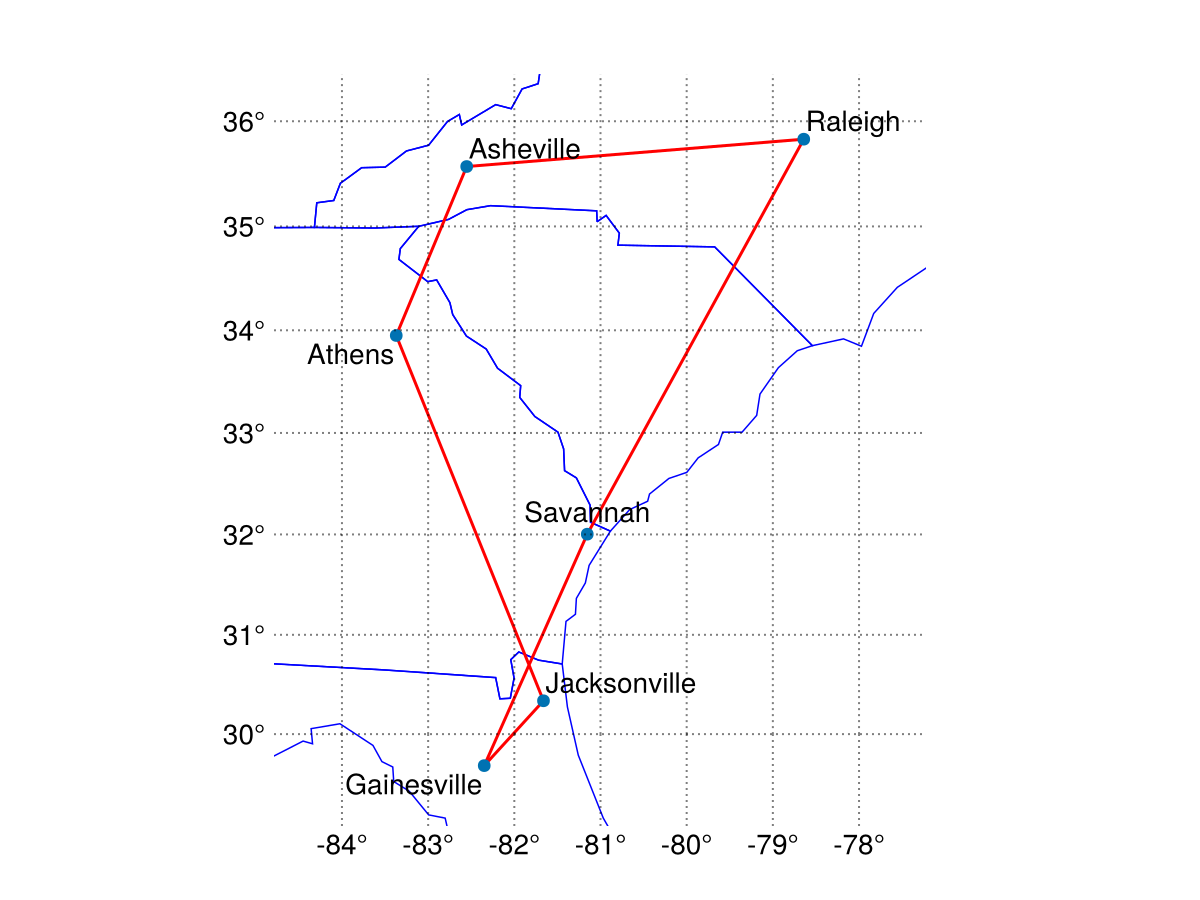

In [23]:
fig, ax = makemap(x, y; xexpand=0.3)

loc = rte2loc(rte, sh, tr)
lines!(ax, x[loc], y[loc], color=:red)
scatter!(ax, x, y)
text!(ax, x, y, text=City; aligntext(x, y)...)
fig

In [24]:
include("rtefun.jl")   # Load `twoopt`

r, TC = twoopt(rte, rTDh)
@show TC
hcat(rte, r)

TC = 1348.4042743937814


10×2 Matrix{Int64}:
 2  2
 1  1
 4  4
 5  3
 3  5
 4  4
 5  3
 3  5
 1  1
 2  2

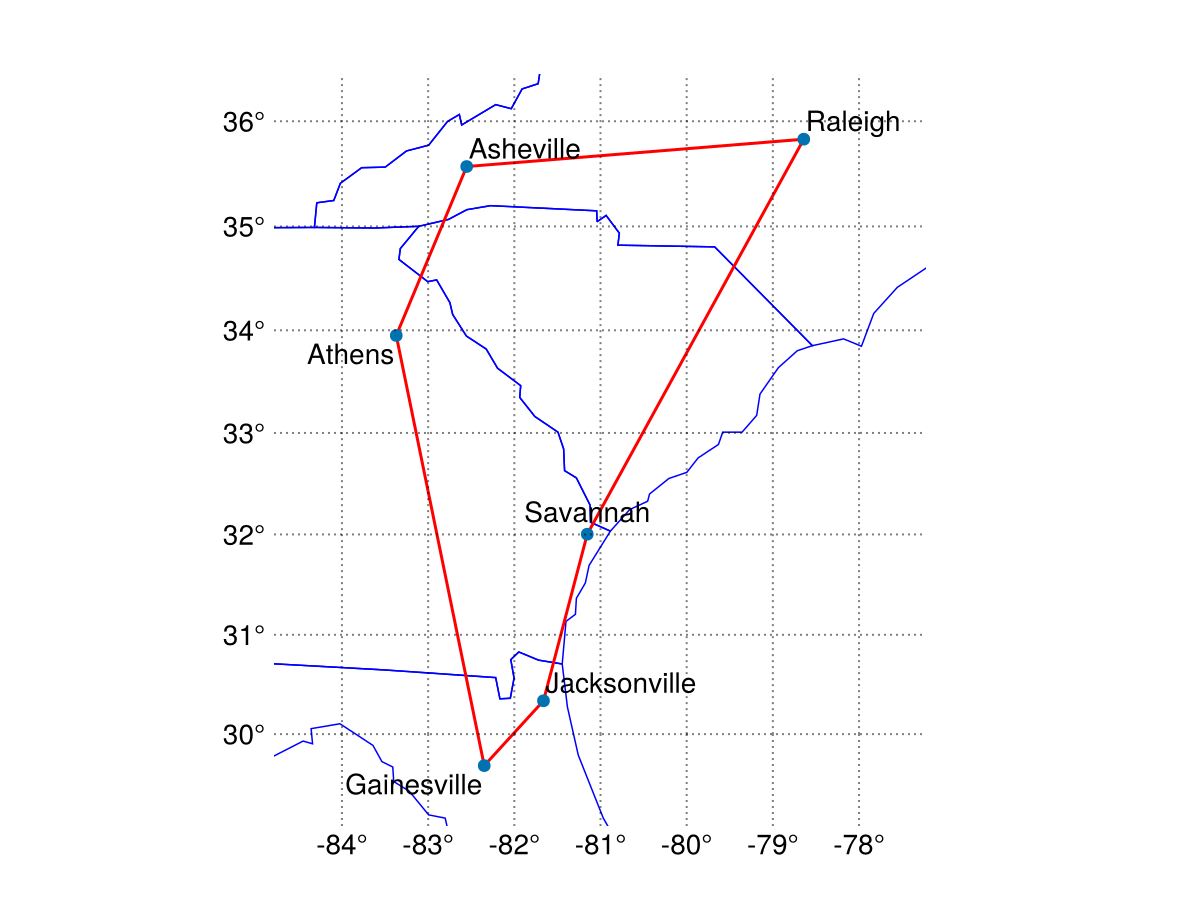

In [25]:
fig, ax = makemap(x, y; xexpand=0.3)

loc = rte2loc(r, sh, tr)
lines!(ax, x[loc], y[loc], color=:red)
scatter!(ax, x, y)
text!(ax, x, y, text=City; aligntext(x, y)...)
fig

# 2. The Tour of North Carolina

In [33]:
using Logjam.DataTools, DataFrames, CSV

include("rtefun.jl")

function dgc(xy₁, xy₂; unit=:mi)
    length(xy₁) == length(xy₂) == 2 || error("Inputs must have length 2.")
    unit in [:mi, :km] || error("Unit must be :mi or :km")

    Δx, Δy = xy₂[1] - xy₁[1], xy₂[2] - xy₁[2]
    a = sind(Δy / 2)^2 + cosd(xy₁[2]) * cosd(xy₂[2]) * sind(Δx / 2)^2
    2 * asin(min(sqrt(a), 1.0)) * (unit == :mi ? 3958.75 : 6371.00)
end

Dgc(X₁, X₂) = [dgc(i, j) for i in eachrow(X₁), j in eachrow(X₂)]

df = filter(r -> (r.STFIP == st2fips(:NC)), uscounty())
XY = hcat(df.LON, df.LAT)
D = Dgc(XY, XY)
n = nrow(df)
sh = DataFrame(b = ones(Int, n-1), e = [2:n;])  # Node 1 has same b,e so can be ignored
tr = (b = 1, e = 1)
rTDh(rte) = rteTC(rte, sh, D, tr)
rte = savings(rTDh, sh)[1]
rTDh(rte)

2443.412422738106

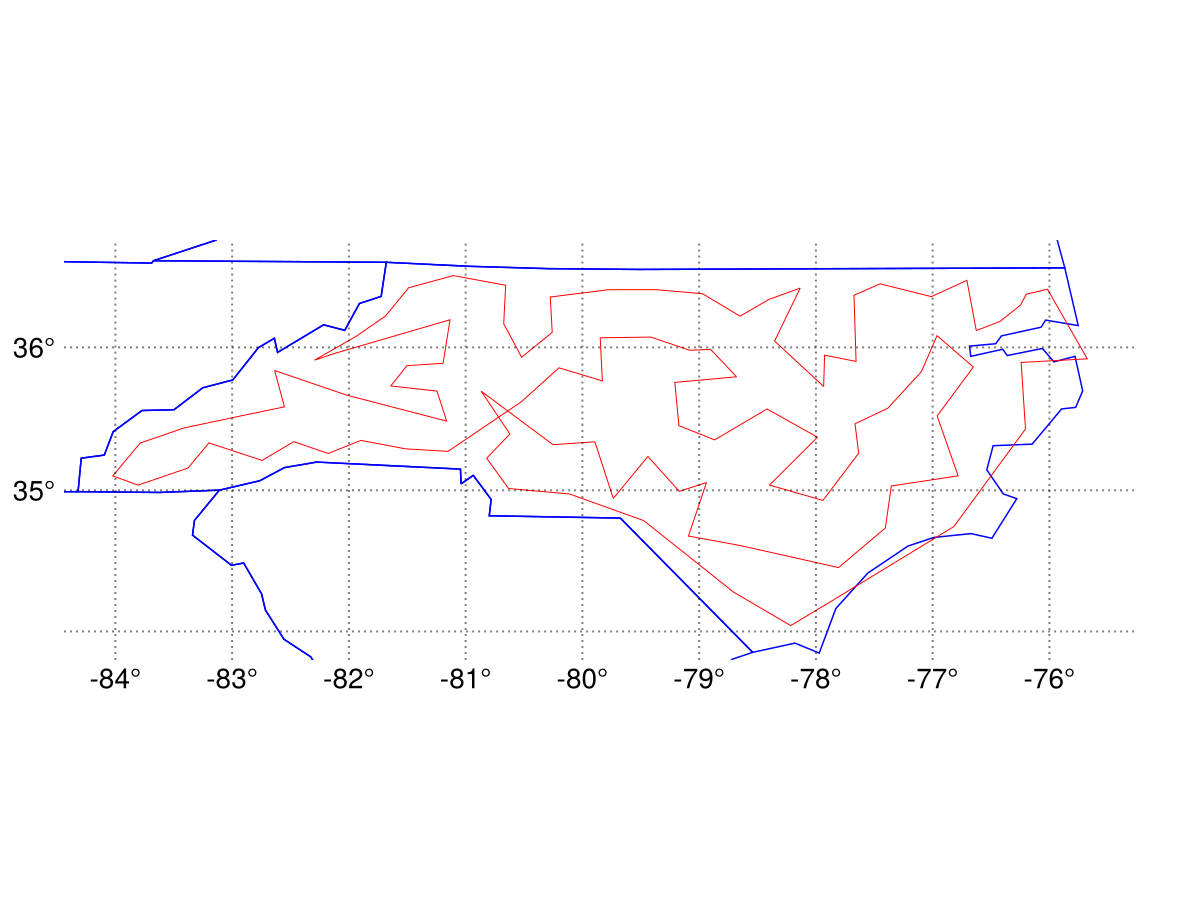

In [31]:
fig, ax = makemap(df.LON, df.LAT; xexpand=0.05)
loc = rte2loc(rte, sh, tr)
lines!(ax, df.LON[loc], df.LAT[loc], color=:red, linewidth=.5)
fig

In [34]:
rte′, TD = twoopt(rte, rTDh)
TD

2169.0242211847944

Multi-start random tour construction and two-opt improvement results from `Rte-1`:

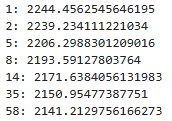

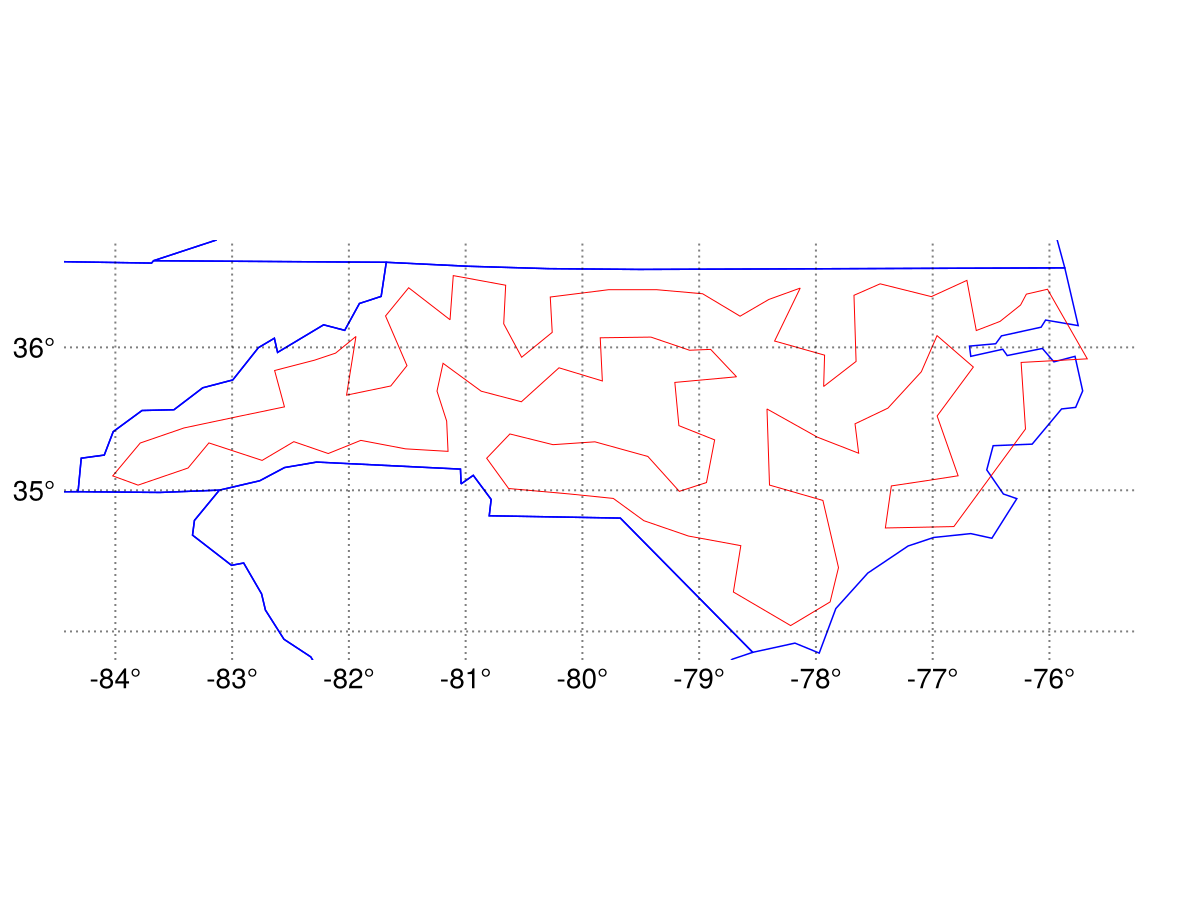

In [35]:
fig, ax = makemap(df.LON, df.LAT; xexpand=0.05)
loc = rte2loc(rte′, sh, tr)
lines!(ax, df.LON[loc], df.LAT[loc], color=:red, linewidth=.5)
fig